### Topic: Convex optimization
### Author: Ivana Benova
### Last edits: 03.05.2021

In [1]:
#importation of libraries
import cvxpy as cp
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
import time

### Definition of functions

In [2]:
'''Genration of population of zones between 100 and max_size
    Inputs: type_OD -string, according to the characteristic of population, OD_random is number
                     generated from uniform distribution, O=D=1000 is constant population of 1000,
                     O=D_linear is linear growth of population,
            max_size - integer, maximal number of inhabitants of zone, 
            num_cities - integer, number of zones,
            OD_relation - string, according to characteristic of population, equal is O=D, 
            start_O=100, 
            growth_0=200, 
            start_D=400, 
            growth_D=50 - parameters in case of linar growth of population

    Outputs:O - numpy array, vector of origin,
            D - numpy array, vector of destination'''
def population_of_cities(type_OD, max_size, num_cities, OD_relation, start_O=100, growth_O=200, start_D=400, growth_D=50):
    if type_OD == 'OD_random':
        O = np.sort(np.random.randint(100,max_size, num_cities))
        if OD_relation == 'equal':
            D = O.copy()
        else:
            D = np.sort(np.random.randint(100,max_size, num_cities))
            D = D*(O.sum()/D.sum())
    if type_OD == 'O=D=1000':
        O = 1000*np.ones(num_cities)
        D = O.copy()
    if type_OD == 'O=D_linear':
        O = start_O+growth_O*np.arange(num_cities)
        if OD_relation == 'equal':
            D = O.copy()
        else:
            D = start_D + growth_D*np.arange(num_cities)
            D = D*(O.sum()/D.sum())
    return O[np.newaxis],D[np.newaxis]

In [3]:
'''Generation of coordinates with constant spacing on the streight line or with growing spacing on the streight
line or with random distribution on the streight line or randomly distributed over space
    Inputs: seed - integer, random seed,
            num_cities - integer, number of zones,
            type - string, type of generation, konstant is constant spacing on the streight line,
            zvacsuj is growing spacing on the streight line, nahodne_x is x-coordinate randomly generated form
            normal distribution y- coordinate is constant, nahodne is normal distribution of both coordinates, 
            coef - float, constant spacing between zones, 
            distance_of_cities - float, distance between zones that is aritmeticaly growing, 
            sigma=50 - sigma of normal distribution,
            
    Outputs:x-numpy array, vector of x-coordinates,
            y-numpy array, vector of y-coordinates'''
def generation_of_coordinates(seed, num_cities, type, coef, distance_of_cities, sigma=50):
    np.random.seed(seed)
    if type == 'konstant':
        x = np.array([0])
        y = np.zeros(num_cities)
        for i in np.arange(num_cities-1):
            x = np.append(x,x[-1]+coef)
    if type == 'zvacsuj':
        x = np.array([0])
        y = np.zeros(num_cities)
        for i in np.arange(num_cities-1):
            x = np.append(x,x[-1]+distance_of_cities*(i+1))
    if type == 'nahodne_x':
        x = np.random.normal(0, sigma, num_cities)
        y = np.zeros(num_cities)
    if type == 'nahodne':
        x = np.random.normal(0, sigma, num_cities)
        y = np.random.normal(0, sigma, num_cities)
    return x,y
  

In [4]:
'''Calculation of distance matrix using Euclidean norm
    Inputs: x- numpy array, vector of x-coordinates,
            y- numpy array, vector of y-coordinates,
            
    Outputs:d- numpy array, distance matrix'''
def distance_matrix_d(x,y):
    df = pd.DataFrame([x,y]).T
    d=distance_matrix(df.values, df.values)
    return d

### Simulations
  

In [5]:
seed = 123
n = 10
max_size = 2000
type_coords = 'konstant'
#type_coords = 'zvacsuj'
#type_coords = 'nahodne'
coef = 1
distance_of_cities = 0.8
wanted_avg_length = 0.1
type_OD = 'O=D=1000'
#type_OD = 'O=D_linear'
#type_OD = 'O=D_random'
OD_relation = 'equal'

In [6]:
# random seed
np.random.seed(seed)

In [7]:
# coordinates
x,y = generation_of_coordinates(seed, n, type_coords, coef, distance_of_cities)

In [8]:
stlpec = np.ones((n,1))
riadok = np.ones((1,n))

#distance matrix
d = distance_matrix_d(x,y)

In [9]:
# origin and destination vectors
O, D = population_of_cities(type_OD, max_size, n, OD_relation)

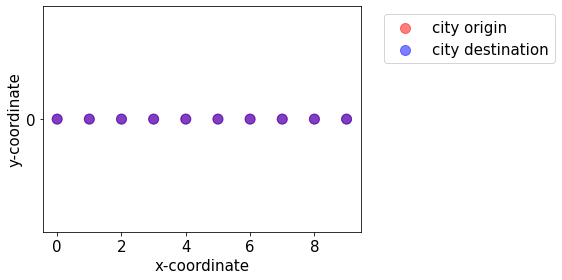

In [10]:
# map of zones
plt.figure(figsize = (8,4))
plt.scatter(x,y, color = 'red', s = O/10, alpha = 0.5, label = 'city origin')
plt.scatter(x,y, color = 'blue', s = D/10, alpha = 0.5, label = 'city destination')
plt.xlabel(r"x-coordinate", size = 15)
plt.ylabel(r"y-coordinate", size = 15)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(ticks = [0], fontsize=15)
plt.tight_layout()

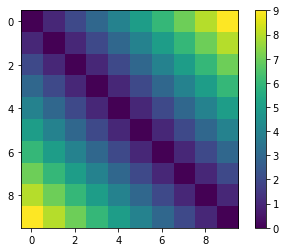

In [ ]:
# distance matrix
plt.imshow(d)
plt.colorbar()

In [ ]:
# variable for optimization
TR = cp.Variable((n, n))

In [ ]:
# constraints for optimization
constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length]

In [ ]:
# objective function for optimization
obj = cp.Maximize(cp.sum(cp.entr(TR)+TR))

In [ ]:
# solution
start_time = time.time()
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS, verbose = True)  # Returns the optimal value.
end_time = time.time()
print(end_time-start_time)
print("status:", prob.status)
print("optimal value", prob.value)



ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -6.561e+01  +3e+02  1e+00  4e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.301e+02  +7.684e+02  +7e+01  1e+00  4e-01  4e+00  2e-01  0.7833  9e-03   1  1  1 |  1  1
 2  +1.634e+03  +1.576e+03  +4e+01  1e+00  4e-01  8e+00  1e-01  0.7833  4e-01   1  1  1 |  6  1
 3  +2.407e+03  +2.353e+03  +2e+01  1e+00  4e-01  1e+01  8e-02  0.9791  7e-01   1  1  1 |  9  0
 4  +1.059e+04  +1.058e+04  +5e+00  1e+00  4e-01  5e+01  2e-02  0.7833  9e-03   1  1  1 |  1  1
 5  +1.461e+04  +1.461e+04  +4e+00  9e-01  3e-01  6e+01  1e-02  0.5013  4e-01   1  1  1 |  6  3
 6  +2.160e+04  +2.161e+04  +2e+00  7e-01  3e-01  6e+01  7e-03  0.5013  2e-01   2  1  2 |  4  3
 7  +2.553e+04  +2.554e+04  +2e+00  6e-01  3e-01  5e+01  5e-03  0.4010  4e-01   1  1  2 |  6  4
 8  +2.814e+04  +2.815e+04  +1e+00  5e-01  3e-

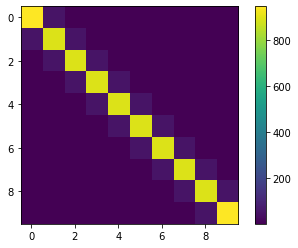

In [ ]:
# OD matrix generated by convex optimization
plt.imshow(TR.value)
plt.colorbar()

In [ ]:
# the mean trip length
np.sum(TR.value*d)/np.sum(TR.value)

0.09999999999999971

In [ ]:
# convergence rate
abs(TR.value.sum(axis=1)-O).max()

4.529483589976735e-06

In [ ]:
# convergence rate
abs(TR.value.sum(axis=0)-D).max()

4.529483589976735e-06

### Scaling and simulations

In [ ]:
# constant population and constant spacing of zones on streight line
seed = 123
n = 10
max_size = 2000
type_coords = 'konstant'
coef = 1
distance_of_cities = 0.8
wanted_avg_length = 2
type_OD = 'O=D=1000'
OD_relation = 'equal'

In [ ]:
# calculation of OD matrices for different number of zones
time_cvx = []
mean_T = []
length = []
entropy = []
j = 0
for a in np.array([10, 20, 40, 50, 100, 200, 500, 750, 1000, 1500]):
# velkost miest(pocet obyvatelov) 
    O, D = population_of_cities(type_OD, max_size, a, OD_relation)

# rovnomerne sa zvacsujuca vzdialenost medzi mestami na priamke
    x,y = generation_of_coordinates(seed, a, type_coords, coef, distance_of_cities)

#   matica vzdialenosti (Euklidovska norma)
    d = distance_matrix_d(x,y)
    wanted_avg_length = np.sqrt(a)
    stlpec = np.ones((a,1))
    riadok = np.ones((1,a))
# matica OD
    TR = cp.Variable((a, a))

    constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length]
    
    obj = cp.Maximize(cp.sum(cp.entr(TR)+TR))
    start_time = time.time()
    prob = cp.Problem(obj, constraints)
    prob.solve(solver = cp.ECOS)
 #   prob.solve(solver=cp.ECOS, abstol=1e-3, reltol = 1e-3, feastol = 1e-3, verbose = True)  # Returns the optimal value.
    end_time = time.time()
    print("status:", prob.status)
    print(end_time-start_time)
    time_cvx.append(end_time-start_time)
    mean_T.append(TR.value.mean())
    length.append(np.sum(TR.value*d)/np.sum(TR.value))
    entropy.append(prob.value)

status: optimal
0.04764819145202637
status: optimal
0.03979229927062988
status: optimal
0.13144207000732422
status: optimal
0.21955108642578125
status: optimal
1.1251606941223145
status: optimal
5.263031959533691
status: optimal
44.10571002960205
status: optimal
125.1362669467926
status: optimal
321.85312485694885
status: optimal
939.5307450294495


In [ ]:
time_cvx

[0.04764819145202637,
 0.03979229927062988,
 0.13144207000732422,
 0.21955108642578125,
 1.1251606941223145,
 5.263031959533691,
 44.10571002960205,
 125.1362669467926,
 321.85312485694885,
 939.5307450294495]

In [ ]:
mean_T

[99.99999931634049,
 49.999999717147546,
 24.999999867983007,
 19.99999993191272,
 9.99999997003382,
 4.999999954028888,
 1.9999999802342041,
 1.3333333280983009,
 0.9999999924685282,
 0.6666666654135186]

In [ ]:
length

[3.1622776601683884,
 4.472135954999574,
 6.324555320336724,
 7.0710678118654595,
 9.999999999999963,
 14.142135623731082,
 22.360679774997564,
 27.38612787525862,
 31.622776601682276,
 38.72983346207652]

In [ ]:
entropy

[-36072.3377025398,
 -60864.64504280782,
 -103310.7588596136,
 -122278.8325213295,
 -203960.19305823438,
 -330755.37920061534,
 -581122.0760886666,
 -711906.8255642863,
 -799276.7412492762,
 -884048.3158600524]

In [ ]:
# linear growth of population and constant spacing of zones on streight line
type_coords = 'konstant'
coef = 1
distance_of_cities = 0.8
wanted_avg_length = 2
type_OD = 'O=D_linear'
OD_relation = 'not_equal'

In [ ]:
# calculation of OD matrices for different number of zones
np.random.seed(seed)
time_cvx = []
mean_T = []
length = []
entropy = []
j = 0
for a in np.array([10, 20, 40, 50, 100, 200, 500, 750, 1000, 1500]):
# velkost miest(pocet obyvatelov) 
    O, D = population_of_cities(type_OD, max_size, a, OD_relation)

# rovnomerne sa zvacsujuca vzdialenost medzi mestami na priamke
    x,y = generation_of_coordinates(seed, a, type_coords, coef, distance_of_cities)

#   matica vzdialenosti (Euklidovska norma)
    d = distance_matrix_d(x,y)
    wanted_avg_length = np.sqrt(a)
    stlpec = np.ones((a,1))
    riadok = np.ones((1,a))
# matica OD
    TR = cp.Variable((a, a))

    constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length]
    
    obj = cp.Maximize(cp.sum(cp.entr(TR)+TR))
    start_time = time.time()
    prob = cp.Problem(obj, constraints)
#    prob.solve(solver = cp.ECOS)
    prob.solve(solver=cp.ECOS, abstol=1e-3, reltol = 1e-3, feastol = 1e-3)  # Returns the optimal value.
    end_time = time.time()
    print("status:", prob.status)
    print(end_time-start_time)
    time_cvx.append(end_time-start_time)
    mean_T.append(TR.value.mean())
    length.append(np.sum(TR.value*d)/np.sum(TR.value))
    entropy.append(prob.value)

status: optimal
0.025708675384521484
status: optimal
0.034882307052612305
status: optimal
0.14562010765075684
status: optimal
0.24419260025024414
status: optimal
1.2793242931365967
status: optimal
7.632089853286743
status: optimal
70.69959306716919
status: optimal
189.29969143867493
status: optimal
406.44550132751465
status: optimal
1217.6107304096222


In [ ]:
time_cvx

[0.025708675384521484,
 0.034882307052612305,
 0.14562010765075684,
 0.24419260025024414,
 1.2793242931365967,
 7.632089853286743,
 70.69959306716919,
 189.29969143867493,
 406.44550132751465,
 1217.6107304096222]

In [ ]:
mean_T

[99.95827062827927,
 99.9447168602551,
 99.95599654914344,
 99.95905945704752,
 99.93038614361056,
 99.91984873231847,
 99.96768374934928,
 99.91981498978026,
 99.91957651037625,
 99.9192157576364]

In [ ]:
length

[3.1622776601745985,
 4.472135954997144,
 6.324555320333563,
 7.071067811867065,
 9.999999999989692,
 14.142135623719653,
 22.36067977499286,
 27.386127875248377,
 31.622776601673138,
 38.72983346206546]

In [ ]:
entropy

[-38227.8620326249,
 -157221.00359372297,
 -665796.5475871867,
 -1061825.6868425717,
 -4533987.691334602,
 -19363302.412004944,
 -131673470.66758573,
 -306973709.5457156,
 -559489166.2609211,
 -1302795935.726053]

In [11]:
# constant population and normal distribution of zones
type_coords = 'nahodne'
coef = 1
distance_of_cities = 0.8
wanted_avg_length = 2
type_OD = 'O=D=1000'
OD_relation = 'equal'

In [12]:
# calculation of OD matrices for different number of zones
time_cvx = []
mean_T = []
length = []
entropy = []
j = 0
for a in np.array([10, 20, 40, 50, 100, 200, 500, 750, 1000, 1500]):
# velkost miest(pocet obyvatelov) 
    O, D = population_of_cities(type_OD, max_size, a, OD_relation)

# rovnomerne sa zvacsujuca vzdialenost medzi mestami na priamke
    x,y = generation_of_coordinates(seed, a, type_coords, coef, distance_of_cities)

#   matica vzdialenosti (Euklidovska norma)
    d = distance_matrix_d(x,y)
    wanted_avg_length = np.sqrt(d.max())
    stlpec = np.ones((a,1))
    riadok = np.ones((1,a))
# matica OD
    TR = cp.Variable((a, a))

    constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length]
    
    obj = cp.Maximize(cp.sum(cp.entr(TR)+TR))
    start_time = time.time()
    prob = cp.Problem(obj, constraints)
#    prob.solve(solver=cp.ECOS, max_iters= 300, verbose = True, abstol=1e-3, reltol = 1e-3, feastol = 1e-3)  # Returns the optimal value.
    prob.solve(solver=cp.ECOS, max_iters = 300)
    end_time = time.time()
    print("status:", prob.status)
    print(end_time-start_time)
    time_cvx.append(end_time-start_time)
    mean_T.append(TR.value.mean())
    length.append(np.sum(TR.value*d)/np.sum(TR.value))
    entropy.append(prob.value)

status: optimal
0.02762293815612793
status: optimal
0.05368971824645996
status: optimal
0.2530972957611084
status: optimal
0.41989970207214355
status: optimal
2.371194839477539
status: optimal
14.656854629516602
status: optimal
171.91375470161438
status: optimal
558.0112898349762
status: optimal
1183.2800755500793
status: optimal
3498.430337667465


In [13]:
time_cvx

[0.02762293815612793,
 0.05368971824645996,
 0.2530972957611084,
 0.41989970207214355,
 2.371194839477539,
 14.656854629516602,
 171.91375470161438,
 558.0112898349762,
 1183.2800755500793,
 3498.430337667465]

In [14]:
mean_T

[99.9999990802391,
 49.99999976218129,
 24.99999989183083,
 19.999999935964656,
 9.999999975150974,
 4.999999959637623,
 1.999999982885199,
 1.3333333283014575,
 0.9999999914794373,
 0.6666666639824828]

In [15]:
length

[15.585571360515392,
 15.404861217026337,
 16.770386744267824,
 16.13715731638147,
 17.829277014860374,
 17.201292358696865,
 18.469158700271738,
 18.884275146691635,
 19.277682184434198,
 18.75134023547744]

In [16]:
entropy

[-49300.89129824403,
 -92419.23419161905,
 -165396.94170771664,
 -201203.00937409274,
 -334401.3553616439,
 -561412.9871460119,
 -965750.4093637705,
 -1111974.1848265226,
 -1183285.7027504968,
 -1287946.9953779785]

### New constraints on OD matrix

In [ ]:
seed = 1234
n = 10
max_size = 2000
type_coords = 'konstant'
coef = 1
distance_of_cities = 0.8
wanted_avg_length = 2.5
type_OD = 'O=D=1000'
OD_relation = 'equal'

### 1. approach addition of equation constraints

In [ ]:
time_equal = []
entropy_equal = []

In [ ]:
np.random.seed(seed)

In [ ]:
x,y = generation_of_coordinates(seed, n, type_coords, coef, distance_of_cities)
O, D = population_of_cities(type_OD, max_size, n, OD_relation)

In [ ]:
stlpec = np.ones((n,1))
riadok = np.ones((1,n))

d = distance_matrix_d(x,y)

In [ ]:
# zero constraints
TR = cp.Variable((n, n))

constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length]
               
obj = cp.Maximize(cp.sum(cp.entr(TR)+TR))

0.019326448440551758
status: optimal
optimal value -36738.132568841305


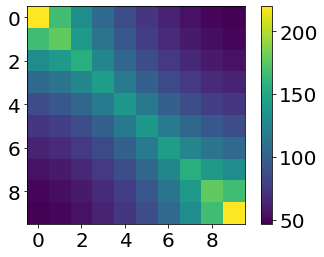

In [ ]:
time_plt = []
start_time = time.time()
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS)  # Returns the optimal value.
end_time = time.time()
print(end_time-start_time)
print("status:", prob.status)
print("optimal value", prob.value)
image = plt.imshow(TR.value)
cbar = plt.colorbar(image, extend='neither', spacing='proportional',
                orientation='vertical', shrink=1, format="%.0f")
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)
cbar.ax.tick_params(labelsize=20) 
time_equal.append(end_time-start_time)
entropy_equal.append(prob.value)

In [ ]:
TR.value

array([[220.04405434, 166.52406693, 131.10883469, 106.06445415,
         87.62632548,  73.74062365,  63.21010106,  55.33411842,
         49.77169877,  46.57571554],
       [166.52406693, 177.9508112 , 140.10541861, 113.342523  ,
         93.63918229,  78.80065346,  67.54753392,  59.13110693,
         53.18699793,  49.77169877],
       [131.10883469, 140.10541861, 155.76341597, 126.00953394,
        104.10417415,  87.60731097,  75.09655758,  65.73952176,
         59.13110693,  55.33411842],
       [106.06445415, 113.342523  , 126.00953394, 143.94512135,
        118.92184191, 100.07689886,  85.78542725,  75.09655758,
         67.54753392,  63.21010106],
       [ 87.62632548,  93.63918229, 104.10417415, 118.92184191,
        138.73371726, 116.74926499, 100.07689886,  87.60731097,
         78.80065346,  73.74062365],
       [ 73.74062365,  78.80065346,  87.60731097, 100.07689886,
        116.74926499, 138.73371726, 118.92184191, 104.10417415,
         93.63918229,  87.62632548],
       [ 6

In [ ]:
np.random.seed(seed)
T_1 = np.random.randint(0,n,1)
print(T_1)
T_2 = np.random.randint(0,n,1)
print(T_2)
T1_value = np.random.randint(0,500,1)
print(T1_value)

[3]
[6]
[53]


In [ ]:
# one constraint
TR = cp.Variable((n, n))

constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length,
               TR[T_1,T_2] == T1_value]
               
obj = cp.Maximize(cp.sum(cp.entr(TR)+TR))

0.035832881927490234
status: optimal
optimal value -36746.65155380378


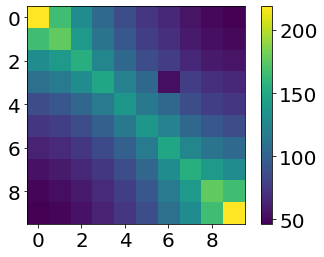

In [ ]:
start_time = time.time()
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS)  # Returns the optimal value.
end_time = time.time()
print(end_time-start_time)
print("status:", prob.status)
print("optimal value", prob.value)
image = plt.imshow(TR.value)
cbar = plt.colorbar(image, extend='neither', spacing='proportional',
                orientation='vertical', shrink=1, format="%.0f")
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)
cbar.ax.tick_params(labelsize=20) 
time_equal.append(end_time-start_time)
entropy_equal.append(prob.value)

In [ ]:
TR.value

array([[218.78677315, 165.7321615 , 130.56583346, 105.66320013,
         87.4712986 ,  73.7393684 ,  65.81083029,  55.48759217,
         49.96005667,  46.782883  ],
       [165.73216159, 176.98753732, 139.43296287, 112.8391159 ,
         93.41174617,  78.74723863,  70.28024905,  59.25592861,
         53.35300054,  49.96005667],
       [130.56583345, 139.4329629 , 154.85970095, 125.32353454,
        103.74673804,  87.45976252,  78.0559928 ,  65.81195139,
         59.25592861,  55.48759217],
       [109.84513695, 117.30506105, 130.28358784, 148.63946004,
        123.04838973, 103.73128975,  52.99999986,  78.0559928 ,
         70.28024905,  65.81083029],
       [ 87.30370703,  93.23277301, 103.54796342, 118.13700884,
        137.87260346, 116.22828231, 103.73128975,  87.45976252,
         78.74723863,  73.7393684 ],
       [ 73.45961501,  78.44848634,  87.12795653,  99.40355977,
        116.00960371, 137.87260346, 123.04838973, 103.74673804,
         93.41174617,  87.4712986 ],
       [ 6

In [ ]:
T_3 = np.random.randint(0,n,1)
print(T_3)
T_4 = np.random.randint(0,n,1)
print(T_4)
T2_value = np.random.randint(0,500,1)
print(T2_value)

[4]
[8]
[143]


In [ ]:
# two constraints
TR = cp.Variable((n, n))

constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length,
               TR[T_1,T_2] == T1_value,
               TR[T_3,T_4] == T2_value]
               
obj = cp.Maximize(cp.sum(cp.entr(TR)+TR))

0.0371098518371582
status: optimal
optimal value -36772.81896108887


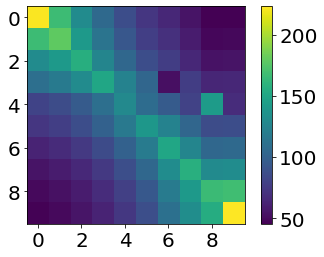

In [ ]:
start_time = time.time()
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS)  # Returns the optimal value.
end_time = time.time()
print(end_time-start_time)
print("status:", prob.status)
print("optimal value", prob.value)
image = plt.imshow(TR.value)
cbar = plt.colorbar(image, extend='neither', spacing='proportional',
                orientation='vertical', shrink=1, format="%.0f")
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)
cbar.ax.tick_params(labelsize=20) 
time_equal.append(end_time-start_time)
entropy_equal.append(prob.value)

In [ ]:
TR.value

array([[221.87641664, 167.4259128 , 131.5097651 , 106.16957411,
         87.72299749,  73.57321344,  65.36456252,  54.87264779,
         45.49222755,  45.99267624],
       [167.42591305, 179.14182142, 140.71236731, 113.59896785,
         93.86155912,  78.72162422,  69.93856832,  58.71245833,
         48.67562089,  49.21109316],
       [131.50976519, 140.71236711, 156.72220382, 126.52392193,
        104.5408495 ,  87.67833768,  77.89597599,  65.39259334,
         54.21379371,  54.81018542],
       [110.38571201, 118.11013441, 131.54835588, 150.58803846,
        124.42391279, 104.35424894,  52.99999967,  77.82988514,
         64.52494478,  65.23476162],
       [ 80.90012662,  86.56124871,  96.40993146, 110.3638457 ,
        129.30137453, 108.44497274,  96.34565453,  80.88084296,
        142.9999991 ,  67.79199733],
       [ 73.55810299,  78.70545615,  87.66033011, 100.34786875,
        117.56673821, 139.8149751 , 124.21567312, 104.27733769,
         86.45123782,  87.40227374],
       [ 6

In [ ]:
T_5 = np.random.randint(0,n,1)
print(T_5)
T_6 = np.random.randint(0,n,1)
print(T_6)
T3_value = np.random.randint(0,500,1)
print(T3_value)
T_7 = np.random.randint(0,n,1)
print(T_7)
T_8 = np.random.randint(0,n,1)
print(T_8)
T4_value = np.random.randint(0,500,1)
print(T4_value)

[1]
[7]
[233]
[6]
[8]
[368]


In [ ]:
# four constraints
TR = cp.Variable((n, n))

constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length,
               TR[T_1,T_2] == T1_value,
               TR[T_3,T_4] == T2_value,
               TR[T_5,T_6] == T3_value,
               TR[T_7,T_8] == T4_value]
               
obj = cp.Maximize(cp.sum(cp.entr(TR)+TR))

0.029266357421875
status: optimal
optimal value -37259.165425367726


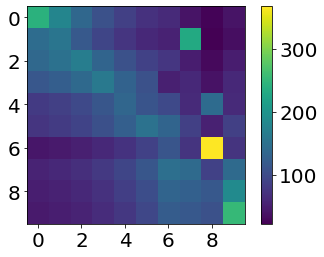

In [ ]:
start_time = time.time()
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS)  # Returns the optimal value.
end_time = time.time()
print(end_time-start_time)
print("status:", prob.status)
print("optimal value", prob.value)
image = plt.imshow(TR.value)
cbar = plt.colorbar(image, extend='neither', spacing='proportional',
                orientation='vertical', shrink=1, format="%.0f")
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)
cbar.ax.tick_params(labelsize=20) 
time_equal.append(end_time-start_time)
entropy_equal.append(prob.value)

In [ ]:
TR.value

array([[243.48377423, 179.8474451 , 137.24802814, 108.18717183,
         87.61938877,  72.08950037,  63.19425782,  41.20659809,
         25.85423766,  41.26958983],
       [144.39345121, 156.53948148, 119.46088304,  94.16627297,
         76.26404493,  62.74680713,  55.00437492, 232.9999981 ,
         22.50356644,  35.92111163],
       [139.15713965, 150.86270422, 168.9763334 , 133.19733653,
        107.87479667,  88.75478718,  77.80318742,  50.73253154,
         31.83108985,  50.81008537],
       [115.71548307, 125.44919184, 140.51149788, 162.56374334,
        131.6582676 , 108.32281288,  52.99999957,  61.9176803 ,
         38.84898279,  62.01233255],
       [ 81.43706435,  88.2873549 ,  98.88775054, 114.40745302,
        135.99437122, 111.8903739 ,  98.08403574,  63.95690983,
        142.99999883,  64.05467951],
       [ 75.82744058,  82.20586306,  92.07607239, 106.52673212,
        126.62667928, 152.9111606 , 134.04319693,  87.40452533,
         54.84018281,  87.53813872],
       [ 4

In [ ]:
T_9 = np.random.randint(0,n,1)
print(T_9)
T_10 = np.random.randint(0,n,1)
print(T_10)
T5_value = np.random.randint(0,500,1)
print(T5_value)
T_11 = np.random.randint(0,n,1)
print(T_11)
T_12 = np.random.randint(0,n,1)
print(T_12)
T6_value = np.random.randint(0,500,1)
print(T6_value)
T_13 = np.random.randint(0,n,1)
print(T_13)
T_14 = np.random.randint(0,n,1)
print(T_14)
T7_value = np.random.randint(0,500,1)
print(T7_value)
T_15 = np.random.randint(0,n,1)
print(T_15)
T_16 = np.random.randint(0,n,1)
print(T_16)
T8_value = np.random.randint(0,500,1)
print(T8_value)

[5]
[0]
[457]
[6]
[2]
[240]
[5]
[2]
[422]
[3]
[7]
[139]


In [ ]:
# eight constraints
TR = cp.Variable((n, n))

constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length,
               TR[T_1,T_2] == T1_value,
               TR[T_3,T_4] == T2_value,
               TR[T_5,T_6] == T3_value,
               TR[T_7,T_8] == T4_value,
               TR[T_9,T_10] == T5_value,
               TR[T_11,T_12] == T6_value,
               TR[T_13,T_14] == T7_value,
               TR[T_15,T_16] == T8_value]
               
obj = cp.Maximize(cp.sum(cp.entr(TR)+TR))

0.05623793601989746
status: optimal
optimal value -39175.14167061108


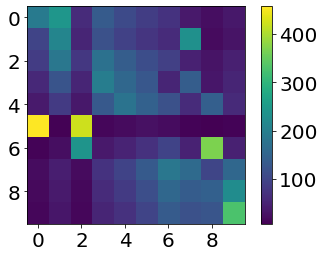

In [ ]:
start_time = time.time()
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS)  # Returns the optimal value.
end_time = time.time()
print(end_time-start_time)
print("status:", prob.status)
print("optimal value", prob.value)
image = plt.imshow(TR.value)
cbar = plt.colorbar(image, extend='neither', spacing='proportional',
                orientation='vertical', shrink=1, format="%.0f")
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)
cbar.ax.tick_params(labelsize=20) 
time_equal.append(end_time-start_time)
entropy_equal.append(prob.value)

In [ ]:
TR.value

array([[192.69836536, 243.51301709,  62.37692546, 135.82169803,
        108.0575924 ,  88.40787872,  72.19271061,  37.31080876,
         23.40280952,  36.21818677],
       [ 99.0130103 , 211.2538514 ,  54.11359866, 117.82884209,
         93.74276103,  76.69612521,  62.62904667, 232.99999831,
         20.30254363,  31.42021544],
       [ 87.15536307, 185.95441149,  80.42230052, 175.11432831,
        139.31818658, 113.98389568,  93.07774965,  48.10466449,
         30.17314115,  46.69595178],
       [ 58.36157284, 124.5200711 ,  53.85293313, 197.98066463,
        157.51028158, 128.86785234,  52.99999961, 138.99999899,
         34.11313388,  52.79348463],
       [ 39.17105745,  83.57524817,  36.14495366, 132.88044958,
        178.49063796, 146.03303941, 119.24865861,  61.63037636,
        142.99999896,  59.82557258],
       [456.99999668,   9.08450392, 421.99999693,  14.44390459,
         19.40166341,  26.80049842,  21.88493439,  11.31062446,
          7.09446934,  10.9794006 ],
       [ 1

In [ ]:
T_17 = np.random.randint(0,n,1)
print(T_17)
T_18 = np.random.randint(0,n,1)
print(T_18)
T9_value = np.random.randint(0,500,1)
print(T9_value)
T_19 = np.random.randint(0,n,1)
print(T_19)
T_20 = np.random.randint(0,n,1)
print(T_20)
T10_value = np.random.randint(0,500,1)
print(T10_value)

[0]
[9]
[331]
[0]
[3]
[258]


In [ ]:
# ten constraints
TR = cp.Variable((n, n))

constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length,
               TR[T_1,T_2] == T1_value,
               TR[T_3,T_4] == T2_value,
               TR[T_5,T_6] == T3_value,
               TR[T_7,T_8] == T4_value,
               TR[T_9,T_10] == T5_value,
               TR[T_11,T_12] == T6_value,
               TR[T_13,T_14] == T7_value,
               TR[T_15,T_16] == T8_value,
               TR[T_17,T_18] == T9_value,
               TR[T_19,T_20] == T10_value]
               
obj = cp.Maximize(cp.sum(cp.entr(TR)+TR))

0.05578255653381348
status: optimal
optimal value -39977.1072463408


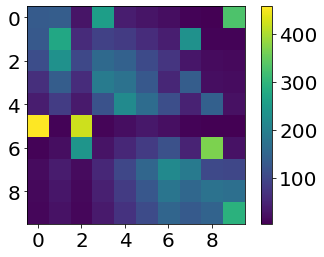

In [ ]:
start_time = time.time()
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS)  # Returns the optimal value.
end_time = time.time()
print(end_time-start_time)
print("status:", prob.status)
print("optimal value", prob.value)
image = plt.imshow(TR.value)
cbar = plt.colorbar(image, extend='neither', spacing='proportional',
                orientation='vertical', shrink=1, format="%.0f")
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)
cbar.ax.tick_params(labelsize=20) 
time_equal.append(end_time-start_time)
entropy_equal.append(prob.value)

In [ ]:
TR.value

array([[134.61577603, 137.78163847,  30.02813271, 257.99999933,
         41.78624715,  31.00993763,  21.57627202,   9.15764045,
          5.04435449, 330.99999914],
       [131.69187955, 275.25628787,  59.98936016,  91.73364611,
         83.47939097,  61.95078246,  43.1044703 , 232.9999994 ,
         10.07746974,   9.71671085],
       [111.64298675, 233.35101757, 103.85551098, 158.81224049,
        144.52220834, 107.2511884 ,  74.62384621,  31.67267767,
         17.44643922,  16.82188177],
       [ 66.46110893, 138.91394208,  61.8252219 , 193.06474524,
        175.69264968, 130.38304415,  52.99999986, 138.99999964,
         21.20927367,  20.45001225],
       [ 40.94807291,  85.5877718 ,  38.09180639, 118.95120899,
        221.05601847, 164.04759486, 114.14197524,  48.44539878,
        142.99999963,  25.73015034],
       [456.99999882,   8.63251319, 421.99999891,  11.99760052,
         22.29604626,  33.78922622,  23.51006142,   9.97840067,
          5.49645834,   5.29969305],
       [ 1

### 2. approach - square of constraints in objective function

In [ ]:
time_obj = [time_equal[0]]
entropy_obj = [entropy_equal[0]]

In [ ]:
TR = cp.Variable((n, n))

constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length]            
obj = cp.Maximize(cp.sum(cp.entr(TR)+TR)-(TR[T_1,T_2] - T1_value)**2)

0.04141664505004883
status: optimal
optimal value -36746.57458761445


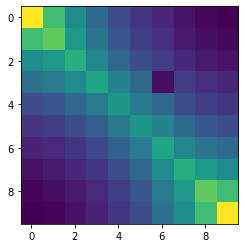

In [ ]:
# one constraint
start_time = time.time()
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS)  # Returns the optimal value.
end_time = time.time()
print(end_time-start_time)
print("status:", prob.status)
print("optimal value", prob.value)
plt.imshow(TR.value)
time_obj.append(end_time-start_time)
entropy_obj.append(prob.value)

In [ ]:
TR.value

array([[218.79732506, 165.73882168, 130.5704083 , 105.66658283,
         87.47262143,  73.7394029 ,  65.78885612,  55.4863248 ,
         49.95849366,  46.78116039],
       [165.73882181, 176.99562868, 139.43861754, 112.84335211,
         93.41367603,  78.74771044,  70.25716944,  59.25490149,
         53.35162596,  49.95849366],
       [130.57040842, 139.43861756, 154.86728649, 125.32929585,
        103.74975594,  87.46102377,  78.03101743,  65.81136541,
         59.25490149,  55.4863248 ],
       [109.81332082, 117.27173254, 130.24766976, 148.60005419,
        123.01369171, 103.70051782,  53.27596733,  78.03101743,
         70.25716944,  65.78885612],
       [ 87.30642636,  93.23619309, 103.55263478, 118.14358885,
        137.87982978, 116.23266938, 103.70051782,  87.46102377,
         78.74771044,  73.7394029 ],
       [ 73.46198272,  78.45144803,  87.13198037,  99.40920277,
        116.01580838, 137.87982978, 123.01369171, 103.74975594,
         93.41367603,  87.47262143],
       [ 6

In [ ]:
TR.value[T_1,T_2]-T1_value

array([0.27596733])

In [ ]:
# two constraints
TR = cp.Variable((n, n))

constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length]            
obj = cp.Maximize(cp.sum(cp.entr(TR)+TR)-(TR[T_1,T_2] - T1_value)**2-(TR[T_3,T_4]-T2_value)**2)

0.16067218780517578
status: optimal
optimal value -36772.59897608441


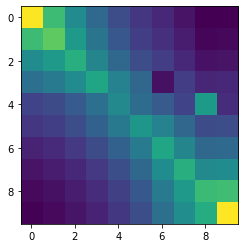

In [ ]:
start_time = time.time()
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS)  # Returns the optimal value.
end_time = time.time()
print(end_time-start_time)
print("status:", prob.status)
print("optimal value", prob.value)
plt.imshow(TR.value)
time_obj.append(end_time-start_time)
entropy_obj.append(prob.value)

In [ ]:
TR.value

array([[221.86903714, 167.42270984, 131.50885624, 106.17004168,
         87.72284473,  73.57420804,  65.34527453,  54.87496338,
         45.51650036,  45.99556085],
       [167.42270952, 179.13738969, 140.71061423, 113.59882596,
         93.86086701,  78.72224171,  69.91752659,  58.7146013 ,
         48.70132149,  49.21389928],
       [131.50885597, 140.71061411, 156.71899635, 126.52275095,
        104.53924147,  87.67832327,  77.87191228,  65.39445124,
         54.24197974,  54.81287141],
       [110.3505096 , 118.07180609, 131.50461358, 150.53661109,
        124.38065899, 104.31955958,  53.27667528,  77.80623664,
         64.53703951,  65.21628645],
       [ 80.94011122,  86.60354136,  96.45626365, 110.41589075,
        129.35894365, 108.49490691,  96.36025819,  80.92039906,
        142.62313846,  67.82654355],
       [ 73.55994825,  78.7069845 ,  87.66133035, 100.34811123,
        117.56392648, 139.81093353, 124.17373336, 104.27730531,
         86.49369101,  87.40403278],
       [ 6

In [ ]:
print(TR.value[T_1,T_2]-T1_value)
print(TR.value[T_3,T_4]-T2_value)

[0.27667528]
[-0.37686154]


In [ ]:
# four constraints
TR = cp.Variable((n, n))

constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length]            
obj = cp.Maximize(cp.sum(cp.entr(TR)+TR)-(TR[T_1,T_2] - T1_value)**2-(TR[T_3,T_4]-T2_value)**2-(TR[T_5,T_6]-T3_value)**2-(TR[T_7, T_8]-T4_value)**2)

0.05395030975341797
status: optimal
optimal value -37256.74701432269


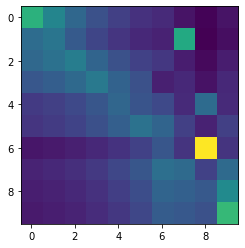

In [ ]:
start_time = time.time()
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS)  # Returns the optimal value.
end_time = time.time()
print(end_time-start_time)
print("status:", prob.status)
print("optimal value", prob.value)
plt.imshow(TR.value)
time_obj.append(end_time-start_time)
entropy_obj.append(prob.value)

In [ ]:
TR.value

array([[243.33514252, 179.76798088, 137.21666842, 108.18193315,
         87.62699086,  72.10808265,  63.19852059,  41.28634299,
         25.96981357,  41.30852002],
       [144.51744241, 156.65830449, 119.57708218,  94.2748433 ,
         76.3622963 ,  62.83838712,  55.07417417, 232.06794975,
         22.63132156,  35.99819437],
       [139.11283975, 150.79966296, 168.89646098, 133.1583536 ,
        107.85780485,  88.75598066,  77.78943034,  50.8182956 ,
         31.96557418,  50.84559274],
       [115.6509893 , 125.36679029, 140.41150218, 162.4337241 ,
        131.57075348, 108.26932059,  53.28850772,  61.99089115,
         38.99332718,  62.02418968],
       [ 81.50077142,  88.34762401,  98.94983012, 114.4691792 ,
        136.04963395, 111.95498274,  98.12199995,  64.10116099,
        142.36922023,  64.13559305],
       [ 75.82200667,  82.19178814,  92.05525971, 106.49326035,
        126.57004435, 152.82789471, 133.94471876,  87.50343432,
         55.04115166,  87.55043699],
       [ 4

In [ ]:
print(TR.value[T_1,T_2]-T1_value)
print(TR.value[T_3,T_4]-T2_value)
print(TR.value[T_5,T_6]-T3_value)
print(TR.value[T_7,T_8]-T4_value)

[0.28850772]
[-0.63077977]
[-0.93205025]
[-1.02829942]


In [ ]:
# eight constraints
TR = cp.Variable((n, n))

constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length]            
obj = cp.Maximize(cp.sum(cp.entr(TR)+TR)-(TR[T_1,T_2] - T1_value)**2-(TR[T_3,T_4]-T2_value)**2-(TR[T_5,T_6]-T3_value)**2-(TR[T_7, T_8]-T4_value)**2-\
                  (TR[T_9,T_10] - T5_value)**2-(TR[T_11,T_12]-T6_value)**2-(TR[T_13,T_14]-T7_value)**2-(TR[T_15, T_16]-T8_value)**2)

0.08043789863586426
status: optimal
optimal value -39158.66330201077


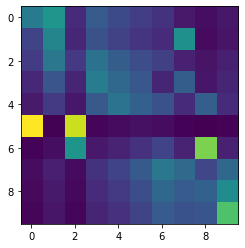

In [ ]:
start_time = time.time()
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS)  # Returns the optimal value.
end_time = time.time()
print(end_time-start_time)
print("status:", prob.status)
print("optimal value", prob.value)
plt.imshow(TR.value)
time_obj.append(end_time-start_time)
entropy_obj.append(prob.value)

In [ ]:
TR.value

array([[192.91695871, 242.84756773,  63.00799298, 135.58991245,
        107.89468728,  88.28421106,  72.12656162,  37.44185546,
         23.56040499,  36.32984045],
       [ 99.42416219, 210.95251747,  54.73266553, 117.78183928,
         93.72404281,  76.68916205,  62.65362182, 232.01758587,
         20.46603452,  31.5583612 ],
       [ 87.48336968, 185.61722789,  81.17262164, 174.67924473,
        138.99973989, 113.73574246,  92.9199903 ,  48.23600026,
         30.35265446,  46.80340144],
       [ 58.68350068, 124.51130864,  54.45027575, 197.49733377,
        157.15706515, 128.59287028,  53.33892269, 138.53388116,
         34.31757579,  52.91725882],
       [ 39.47546346,  83.75678805,  36.62783975, 132.85333237,
        178.18639673, 145.80000056, 119.11589393,  61.83464159,
        142.35147042,  59.99816588],
       [454.68760248,   9.45988675, 419.69021428,  15.00508221,
         20.12521428,  27.75574686,  22.67592915,  11.77137478,
          7.40717443,  11.42176752],
       [ 1

In [ ]:
print(TR.value[T_1,T_2]-T1_value)
print(TR.value[T_3,T_4]-T2_value)
print(TR.value[T_5,T_6]-T3_value)
print(TR.value[T_7,T_8]-T4_value)
print(TR.value[T_9,T_10]-T5_value)
print(TR.value[T_11,T_12]-T6_value)
print(TR.value[T_13,T_14]-T7_value)
print(TR.value[T_15,T_16]-T8_value)

[0.33892269]
[-0.64852958]
[-0.98241413]
[-1.21982334]
[-2.31239752]
[-1.55678716]
[-2.30978572]
[-0.46611884]


In [ ]:
# ten constraints
TR = cp.Variable((n, n))

constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length]            
obj = cp.Maximize(cp.sum(cp.entr(TR)+TR)-(TR[T_1,T_2] - T1_value)**2-(TR[T_3,T_4]-T2_value)**2-(TR[T_5,T_6]-T3_value)**2-(TR[T_7, T_8]-T4_value)**2-\
                  (TR[T_9,T_10] - T5_value)**2-(TR[T_11,T_12]-T6_value)**2-(TR[T_13,T_14]-T7_value)**2-(TR[T_15, T_16]-T8_value)**2 - (TR[T_17, T_18]-T9_value)**2 -\
                  (TR[T_19, T_20]-T10_value)**2)

0.0954427719116211
status: optimal
optimal value -39953.9852395677


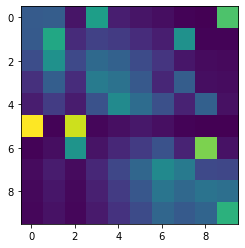

In [ ]:
start_time = time.time()
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS)  # Returns the optimal value.
end_time = time.time()
print(end_time-start_time)
print("status:", prob.status)
print("optimal value", prob.value)
plt.imshow(TR.value)
time_obj.append(end_time-start_time)
entropy_obj.append(prob.value)

In [ ]:
TR.value

array([[135.10528963, 138.20433751,  30.5921317 , 257.1435529 ,
         42.2010743 ,  31.36523319,  21.90482348,   9.37934064,
          5.19599599, 328.90821464],
       [131.86373427, 274.12315936,  60.67835385,  91.98151416,
         83.70426009,  62.21177209,  43.44740139, 231.73886982,
         10.30606488,   9.94486407],
       [111.74751106, 232.30481798, 104.50024703, 158.41054225,
        144.15545723, 107.14109941,  74.82510456,  32.039069  ,
         17.74910274,  17.12704272],
       [ 66.81214716, 138.89153802,  62.47911752, 192.47427317,
        175.15385313, 130.18013158,  53.26730131, 138.36591256,
         21.56577189,  20.80994762],
       [ 41.31215638,  85.88122341,  38.63290119, 119.01319749,
        220.09651621, 163.5830039 , 114.24295099,  48.91724253,
        142.17123743,  26.14956446],
       [454.67364226,   9.01309489, 419.68015975,  12.49024182,
         23.09877204,  34.88871243,  24.36554749,  10.43298847,
          5.77969912,   5.57713572],
       [ 1

In [ ]:
print(TR.value[T_1,T_2]-T1_value)
print(TR.value[T_3,T_4]-T2_value)
print(TR.value[T_5,T_6]-T3_value)
print(TR.value[T_7,T_8]-T4_value)
print(TR.value[T_9,T_10]-T5_value)
print(TR.value[T_11,T_12]-T6_value)
print(TR.value[T_13,T_14]-T7_value)
print(TR.value[T_15,T_16]-T8_value)
print(TR.value[T_17,T_18]-T9_value)
print(TR.value[T_19,T_20]-T10_value)

[0.26730131]
[-0.82876257]
[-1.26113018]
[-1.28687626]
[-2.32635774]
[-1.60338522]
[-2.31984025]
[-0.63408744]
[-2.09178536]
[-0.8564471]


### 3. approach - addition of absolute value of constraints in objective function

In [ ]:
time_abs = [time_equal[0]]
entropy_abs = [entropy_equal[0]]

0.037568092346191406
status: optimal
optimal value -36746.65147270903


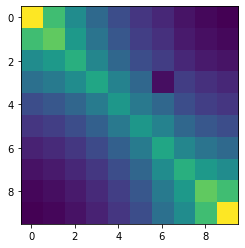

In [ ]:
# one constraint
TR = cp.Variable((n, n))

constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length]            
obj = cp.Maximize(cp.sum(cp.entr(TR)+TR)-cp.abs(TR[T_1,T_2] - T1_value))

start_time = time.time()
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS)  # Returns the optimal value.
end_time = time.time()
print(end_time-start_time)
print("status:", prob.status)
print("optimal value", prob.value)
plt.imshow(TR.value)
time_abs.append(end_time-start_time)
entropy_abs.append(prob.value)

In [ ]:
TR.value

array([[218.78681392, 165.73213921, 130.56581975, 105.66319294,
         87.47129165,  73.73936848,  65.81082701,  55.48759417,
         49.96006096,  46.78288602],
       [165.73213914, 176.98753928, 139.43296781, 112.83911406,
         93.41174521,  78.747239  ,  70.28024953,  59.25593224,
         53.35300688,  49.96006096],
       [130.5658194 , 139.43296806, 154.85971602, 125.32352714,
        103.74673436,  87.45976038,  78.05599124,  65.81195111,
         59.25593224,  55.48759417],
       [109.84512928, 117.30505803, 130.28358164, 148.63946267,
        123.0484024 , 103.7312911 ,  53.00000122,  78.05599124,
         70.28024953,  65.81082701],
       [ 87.30370196,  93.23277376, 103.5479626 , 118.13701025,
        137.87260301, 116.22828358, 103.7312911 ,  87.45976038,
         78.747239  ,  73.73936848],
       [ 73.45961486,  78.44848614,  87.12795453,  99.40355977,
        116.00960218, 137.87260301, 123.0484024 , 103.74673436,
         93.41174521,  87.47129165],
       [ 6

0.036431312561035156
status: optimal
optimal value -36772.81900637142


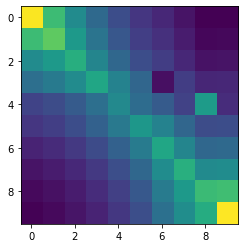

In [ ]:
# two constraints
TR = cp.Variable((n, n))

constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length]            
obj = cp.Maximize(cp.sum(cp.entr(TR)+TR)-cp.abs(TR[T_1,T_2] - T1_value) - cp.abs(TR[T_3,T_4]-T2_value))

start_time = time.time()
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS)  # Returns the optimal value.
end_time = time.time()
print(end_time-start_time)
print("status:", prob.status)
print("optimal value", prob.value)
plt.imshow(TR.value)
time_abs.append(end_time-start_time)
entropy_abs.append(prob.value)

In [ ]:
TR.value

array([[221.87647582, 167.42588885, 131.50974557, 106.16956531,
         87.72298895,  73.57320875,  65.3645678 ,  54.87264984,
         45.49222867,  45.99267585],
       [167.42588889, 179.141817  , 140.71237264, 113.59896896,
         93.8615626 ,  78.72162652,  69.93857358,  58.71246215,
         48.67562807,  49.21109498],
       [131.50974551, 140.71237246, 156.72220974, 126.5239222 ,
        104.54085074,  87.6783395 ,  77.8959773 ,  65.39259351,
         54.21379689,  54.81018756],
       [110.38570101, 118.11013852, 131.54835466, 150.58803811,
        124.42391014, 104.35425014,  53.00000093,  77.82988718,
         64.52494738,  65.23476733],
       [ 80.90012078,  86.56125062,  96.40993296, 110.36384657,
        129.30137937, 108.44497536,  96.34565406,  80.8808437 ,
        142.99999683,  67.79199516],
       [ 73.55809822,  78.70545954,  87.66033325, 100.34786864,
        117.56674065, 139.81497961, 124.21567147, 104.27734003,
         86.45123938,  87.40226462],
       [ 6

0.04315614700317383
status: optimal
optimal value -37127.726335746294


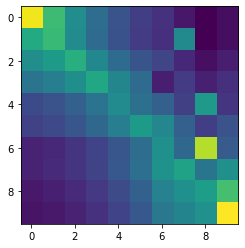

In [ ]:
# four constraints
TR = cp.Variable((n, n))

constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length]            
obj = cp.Maximize(cp.sum(cp.entr(TR)+TR)-cp.abs(TR[T_1,T_2] - T1_value) - cp.abs(TR[T_3,T_4]-T2_value)-cp.abs(TR[T_5,T_6]-T3_value)-\
                  cp.abs(TR[T_7,T_8]-T4_value))

start_time = time.time()
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS)  # Returns the optimal value.
end_time = time.time()
print(end_time-start_time)
print("status:", prob.status)
print("optimal value", prob.value)
plt.imshow(TR.value)
time_abs.append(end_time-start_time)
entropy_abs.append(prob.value)

In [ ]:
TR.value

array([[230.38250293, 172.41241506, 133.93325049, 107.1394681 ,
         87.85024029,  73.14425568,  64.66871505,  49.14595353,
         37.08281284,  44.24038342],
       [158.05944634, 169.96499929, 132.03205161, 105.61860869,
         86.60319444,  72.10596333,  63.75073414, 131.69619672,
         36.55641745,  43.61238537],
       [134.63847967, 144.77988722, 161.60251103, 129.27340437,
        105.99921407,  88.25512118,  78.02861889,  59.29901211,
         44.74374817,  53.38000067],
       [112.62606385, 121.10942295, 135.18166957, 155.38134559,
        127.40672354, 106.07904868,  53.0000006 ,  71.27498803,
         53.78015616,  64.16057843],
       [ 81.16737257,  87.2811624 ,  97.42275123, 111.98025677,
        131.93344971, 109.84800889,  97.11944593,  73.80736993,
        142.9999929 ,  66.44018704],
       [ 74.5535866 ,  80.16920433,  89.48442287, 102.85573468,
        121.18307593, 144.97704359, 128.17792919,  97.41072463,
         73.50073453,  87.68754104],
       [ 5

In [ ]:
print(TR.value[T_1,T_2]-T1_value)
print(TR.value[T_3,T_4]-T2_value)
print(TR.value[T_5,T_6]-T3_value)
print(TR.value[T_7,T_8]-T4_value)

[5.97174115e-07]
[-7.09560149e-06]
[-101.30380328]
[-155.41664159]


0.06594276428222656
status: optimal
optimal value -37948.337065069565


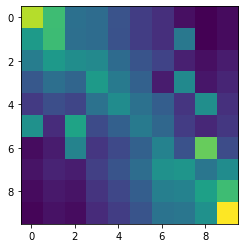

In [ ]:
# eight constraints
TR = cp.Variable((n, n))

constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length]            
obj = cp.Maximize(cp.sum(cp.entr(TR)+TR)-cp.abs(TR[T_1,T_2] - T1_value) - cp.abs(TR[T_3,T_4]-T2_value)-cp.abs(TR[T_5,T_6]-T3_value)-\
                  cp.abs(TR[T_7,T_8]-T4_value)-cp.abs(TR[T_9,T_10]-T5_value)-cp.abs(TR[T_11,T_12]-T6_value)-cp.abs(TR[T_13,T_14]-T7_value)-\
                  cp.abs(TR[T_15,T_16]-T8_value))

start_time = time.time()
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS)  # Returns the optimal value.
end_time = time.time()
print(end_time-start_time)
print("status:", prob.status)
print("optimal value", prob.value)
plt.imshow(TR.value)
time_abs.append(end_time-start_time)
entropy_abs.append(prob.value)

In [ ]:
TR.value

array([[228.32439018, 185.06418235, 115.7389197 , 112.83663694,
         91.64154164,  75.73222575,  65.58307215,  45.25484916,
         36.81574707,  43.00843096],
       [153.79349322, 184.36053889, 115.29886361, 112.40761487,
         91.29310594,  75.44427965,  65.33371468, 122.54770953,
         36.67576767,  42.84490786],
       [127.90147252, 153.3223845 , 141.81512916, 138.25895469,
        112.28856164,  92.79484531,  80.3590673 ,  55.45085576,
         45.11040731,  52.69831772],
       [ 96.09059906, 115.18897625, 106.54373543, 153.62382314,
        124.76731199, 103.1072377 ,  53.00000066, 138.9999965 ,
         50.12357622,  58.55473897],
       [ 73.64161323,  88.27816723,  81.65265467, 117.73374488,
        141.41749968, 116.86689027, 101.20512914,  69.83544248,
        142.99999181,  66.36886254],
       [145.31478217,  64.08336673, 161.12272709,  85.46591967,
        102.6585596 , 125.47102503, 108.65619235,  74.97696329,
         60.99529647,  71.25516352],
       [ 4

0.07408547401428223
status: optimal
optimal value -38313.72060953769


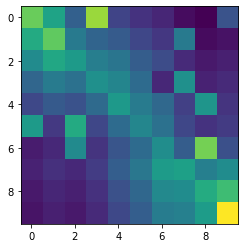

In [ ]:
# ten constraints
TR = cp.Variable((n, n))

constraints = [riadok @ TR == O,
               TR @ stlpec == D.T, 
               cp.sum(cp.multiply(d,TR))/cp.sum(O) == wanted_avg_length]            
obj = cp.Maximize(cp.sum(cp.entr(TR)+TR)-cp.abs(TR[T_1,T_2] - T1_value) - cp.abs(TR[T_3,T_4]-T2_value)-cp.abs(TR[T_5,T_6]-T3_value)-\
                  cp.abs(TR[T_7,T_8]-T4_value)-cp.abs(TR[T_9,T_10]-T5_value)-cp.abs(TR[T_11,T_12]-T6_value)-cp.abs(TR[T_13,T_14]-T7_value)-\
                  cp.abs(TR[T_15,T_16]-T8_value)-cp.abs(TR[T_17,T_18]-T9_value)-cp.abs(TR[T_19,T_20]-T10_value))

start_time = time.time()
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS)  # Returns the optimal value.
end_time = time.time()
print(end_time-start_time)
print("status:", prob.status)
print("optimal value", prob.value)
plt.imshow(TR.value)
time_abs.append(end_time-start_time)
entropy_abs.append(prob.value)

In [ ]:
TR.value

array([[198.16066933, 156.68952869,  95.78757006, 216.18060231,
         73.78630147,  60.21091685,  51.52181707,  35.1788121 ,
         28.19810258,  84.2856763 ],
       [163.59328171, 194.92094488, 119.15923024,  98.93289989,
         91.78976872,  74.90206201,  64.09286764, 118.95814776,
         35.07829047,  38.57250343],
       [134.99698675, 160.84854177, 148.16882187, 123.01834427,
        114.13620256,  93.13714331,  79.69642578,  54.41627931,
         43.61818196,  47.96306919],
       [101.02446732, 120.37037657, 110.88155862, 138.72122042,
        128.70530271, 105.02578497,  53.00000054, 138.99999721,
         49.18589551,  54.0853929 ],
       [ 76.44325925,  91.08193307,  83.90192968, 104.96766297,
        146.7505011 , 119.75098414, 102.46959461,  69.96567387,
        142.99999234,  61.66846571],
       [148.80956822,  65.227302  , 163.32912061,  75.17141142,
        105.09372097, 129.22507594, 110.57647258,  75.50100401,
         60.5189582 ,  66.5473628 ],
       [ 4

### Comparison of time and entropy of the 3 approaches

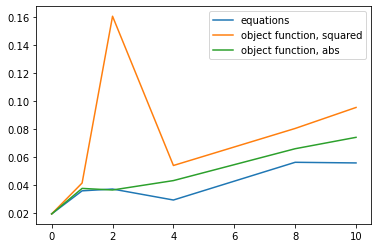

In [ ]:
plt.plot([0,1,2,4,8,10], time_equal, label = 'equations')
plt.plot([0,1,2,4,8,10], time_obj, label = 'object function, squared')
plt.plot([0,1,2,4,8,10], time_abs, label = 'object function, abs')
plt.legend()

In [ ]:
entropy_abs

[-36738.132568841305,
 -36746.65147270903,
 -36772.81900637142,
 -37127.726335746294,
 -37948.337065069565,
 -38313.72060953769]

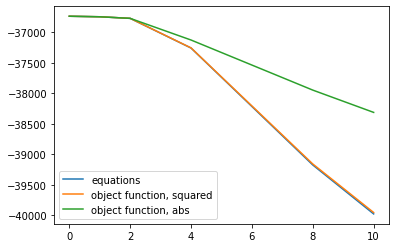

In [ ]:
plt.plot([0,1,2,4,8,10], entropy_equal, label = 'equations')
plt.plot([0,1,2,4,8,10], entropy_obj, label = 'object function, squared')
plt.plot([0,1,2,4,8,10], entropy_abs, label = 'object function, abs')
plt.legend()